<a href="https://colab.research.google.com/github/christianpfitzner/depth_workshop/blob/master/Copy_of_depth_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

First, we will solve the needed dependencies for this workshop. We use the classic numpy library for matrix calculations. Matplotlib is used for visualization. Opencv is applied just for resizing; I haven't found a similar method in numpy. 


In [0]:
import numpy as np                                                              # we need the common numpy library for the upcomming calculation
import matplotlib.pyplot as plt
import cv2

# Introduction to Depth Maps

A depth map can be expressed as a matrix, containing depth values in each cell of the matrix. You can access a cell in a matrix via an index for the row and the column. 

For this tiny example and to save a load of computational power, we create our own tiny depth image. Here, the depth image has a size of 4 x 5 values, containing only either values of 1.0 or 2.0 for depth. 


depth_image = 
[[1.  2.  1.  1.  1. ]
 [1.  1.  0.3 0.3 1. ]
 [1.  1.  0.3 0.3 1. ]
 [1.  1.  1.  1.  1. ]]
columns of the depth image: 5
rows of the depth image: 4


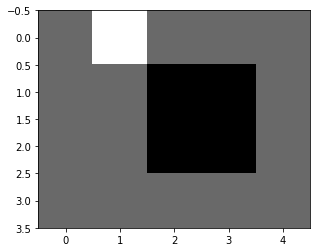

In [2]:



depth_image = np.matrix([[1.0, 2.0, 1.0, 1.0, 1.0],                             # we create a simple depth map based on a numpy matrix
                         [1.0, 1.0, 0.3, 0.3, 1.0], 
                         [1.0, 1.0, 0.3, 0.3, 1.0], 
                         [1.0, 1.0, 1.0, 1.0, 1.0]])


print("depth_image = \n" + str(depth_image))                                    # print the depth image to terminal




cols = np.size(depth_image,1)                                                   # read the columns from the depth image
rows = np.size(depth_image,0)                                                   # read the rows from depth image

print ("columns of the depth image: " + str(cols))                              # output to terminal
print ("rows of the depth image: "    + str(rows))                              # output to terminal

imgplot = plt.imshow(depth_image, cmap='gray')




# Projection: Converting a depth map to a pont cloud

In addition to the depth image, we also need a projection matrix. The process to receive this matrix and it's calculation based on image calibration will be a topic for the upcomming workshops -- till now, we need a little bit of trust. In this example, the values for the projection matrix are just some guessed values -- suitable for our out-of-the-mind-depth-image. We also do the calculation of the inverse projection matrix, based on numpy. 


The general form of the projection matrix looks like this: \\
$\mathrm{P} = \begin{pmatrix} f_x & 0 & c_x \\ 
0 & f_y & c_y\\
0 & 0 & 1\\\end{pmatrix}$

$f_x$: focal length for x axis \\
$f_y$: focal length for y axis \\
$c_x$: center coordinate of x axis in image plane \\
$c_y$: center coordiante of y axis in image plane


In [3]:


projection_matrix     = np.matrix([[20.0, 0, 2.5],                              # defining the projection matrix
                                   [0.0, 20, 2.0], 
                                   [0.0,  0, 1.0]])    
inv_projection_matrix = np.linalg.inv(projection_matrix)                        # calculation of the inverse projection matrix 

pointcloud = np.zeros(((cols)*(rows), 3))                                       # allocation of the point cloud with the size of cols times rows and three columns


print("projection matrix = \n"         + str(projection_matrix))
print("inverse projection matrix = \n" + str(inv_projection_matrix))


projection matrix = 
[[20.   0.   2.5]
 [ 0.  20.   2. ]
 [ 0.   0.   1. ]]
inverse projection matrix = 
[[ 0.05   0.    -0.125]
 [ 0.     0.05  -0.1  ]
 [ 0.     0.     1.   ]]


Now we have our depth image loaded, and an output variable (pointcloud) created, it is time to do the calculation for all of the pixels in the depth image. 

Therefore we create two for-loops, one for the colums, and one for the rows. 

In [0]:
i = 0                                                                           # defining and iterator for the manipulation of the cloud

for r in range(0, rows):
  for c in range(0, cols):
    d = depth_image.item((r, c))                                                # getting the depth value of a pixel from the depth image

    q = np.matrix([[c],[r],[d]])                                            # creating image coordinates with the size of 3x1, containing the pixel coordinates, and depth

    point = inv_projection_matrix*q                                             # calculating the kartesian point
    point = np.transpose(point)                                                 # calculation of the transposed point -- this is only necessary for this example to create a row major point cloud

    pointcloud[i, :] = point                                                    # we modify the complete row of a cloud
    i = i+1


We now have a look at the generated data. The first column contains the cartesian **x values**, the second colum the **values for y**, and the third column contains the **depth value** -- have a close look: The values for the depth are the same for the corresponding pixels in the depth image. 

In [5]:
print ("point cloud = \n" + str(pointcloud))

point cloud = 
[[-0.125  -0.1     1.    ]
 [-0.2    -0.2     2.    ]
 [-0.025  -0.1     1.    ]
 [ 0.025  -0.1     1.    ]
 [ 0.075  -0.1     1.    ]
 [-0.125  -0.05    1.    ]
 [-0.075  -0.05    1.    ]
 [ 0.0625  0.02    0.3   ]
 [ 0.1125  0.02    0.3   ]
 [ 0.075  -0.05    1.    ]
 [-0.125   0.      1.    ]
 [-0.075   0.      1.    ]
 [ 0.0625  0.07    0.3   ]
 [ 0.1125  0.07    0.3   ]
 [ 0.075   0.      1.    ]
 [-0.125   0.05    1.    ]
 [-0.075   0.05    1.    ]
 [-0.025   0.05    1.    ]
 [ 0.025   0.05    1.    ]
 [ 0.075   0.05    1.    ]]


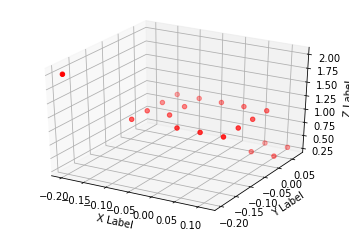

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = pointcloud[:,0]
y = pointcloud[:,1]
z = pointcloud[:,2]

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.scatter(x, y, z, c='r', marker='o')


So, let's try to calculate the depth image, based on this point cloud. Remember, that we now have to apply the inverse projection matrix $\mathrm{P}$ multiplied to the cartesian coordinates. 


In [0]:

output_depth_image = np.zeros((rows, cols))                                     # we generate an image in the same size as the input


for i in range(0, pointcloud.shape[0]):
  point = pointcloud[i,:]
  point = point.reshape(-1, 1)                                                  # transpose the points

  q = projection_matrix * point                                                 # calculate the image coordinates

  c = int(np.round(q[0]))                                                  # get the colum from the first element
  r = int(np.round(q[1]))                                                  # get the row from the second element

  output_depth_image[r,c] = q[2]                                                # finally, the depth value is included in the third value





Ok, seems like we are close to finish this session: Now let's print the the resulting depth image, as well as the initial depth map -- they should be equal. 

[[1.  2.  1.  1.  1. ]
 [1.  1.  0.3 0.3 1. ]
 [1.  1.  0.3 0.3 1. ]
 [1.  1.  1.  1.  1. ]]


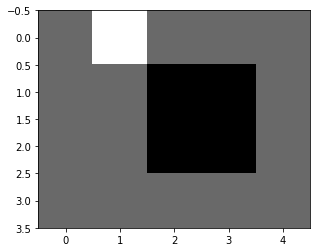

In [8]:
print(output_depth_image)
imgplot = plt.imshow(output_depth_image, cmap='gray')


#Resize the depth map

We will now have a closer look what happens if we change the size of the image. Obviously, we now have more data to calculate, but not more information, if we increase the image by resizing. 

In this first step, we increase the size to 100 times 80, so factor of 10 for the height and width. 

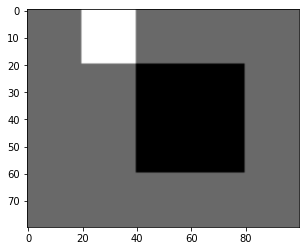

In [9]:
big_depth_image = cv2.resize(depth_image, dsize=(100,80), interpolation=cv2.INTER_NEAREST)
imgplot = plt.imshow(big_depth_image, cmap='gray')

Remember what effect the parameters inside of the projection matrix is: Field of View ($f_x$, $f_y$), as well as the distance to the image's center ($c_x$, $y_y$).

To apply a correct conversion from the data to a point cloud, we now modify the previously defined projection matrix. 

$\begin{pmatrix} 1 & 2 & 3 \end{pmatrix}$

$\mathrm{P} = \begin{pmatrix} f_x & 0 & c_x \\ 
0 & f_y & c_y\\
0 & 0 & 1\\\end{pmatrix}$

# Calculations with a more complex Point Cloud (Kinect)

The next point cloud was generated by a tool called blendsor (https://www.blensor.org/), which is based on the 3d model software blender. Here you can get point clouds based on an sensor model from a 3d modeled scene. Common output format is *.pcd, which is applied by the point cloud library. So in case you need artificial point cloud data with a high amount of data, I suggest you have a look at blendsor. 

The point cloud we here was recorded with a sensor of the size of 100x80 pixels, providing in total a maximum of 8,000 points. 





In [10]:
pc = np.load("pc.npy")
print("Size of loaded point cloud: " + str(pc.shape))

Size of loaded point cloud: (2060, 3)


2,060 is not 8,000, as we expected previously. The reason for this can be, that the camera has a maximum or also a minimum range to aquire 3d data -- which is the case for this scenario. 

In [11]:
print(np.load("pc.npy"))

[[-0.97606  -0.985369 -3.983587]
 [-0.723806 -0.985369 -3.983587]
 [-0.177254 -0.985369 -3.983587]
 ...
 [-0.262199  0.987887 -3.993766]
 [-0.220049  0.987887 -3.993766]
 [-0.177899  0.987887 -3.993766]]


%matplotlib notebook

The projection matrix for this sensor is given by

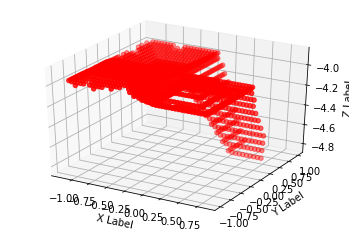

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = pc[:,0]
y = pc[:,1]
z = pc[:,2]

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.scatter(x, y, z, c='r', marker='o')

In [0]:
P = np.matrix([[80.75, 0, 50.0], [0.0, 80.75, 20], [0, 0, 1]]) 

Let's to the same calculation, as we have previously experienced with the small point cloud. 

In [0]:
rows = 80
cols = 100
output_depth_image = np.zeros((rows, cols))                                     # we generate an image in the same size as the input


for i in range(0, pc.shape[0]):
  point = pc[i,:]
  point = point.reshape(-1, 1)                                                  # transpose the points
  point[2] = abs(point[2])
  q = P * point                                                                 # calculate the image coordinates

  c = int(np.round(q[0]/q[2]))                                                       # get the colum from the first element
  r = int(np.round(q[1]/q[2]))                                                       # get the row from the second element
  
  # print(c)
  # print(r)

  if(abs(r) > rows): 
    continue
  if(abs(c) > cols): 
    continue

  # print(q[2])  
  output_depth_image[r,c] = q[2] 




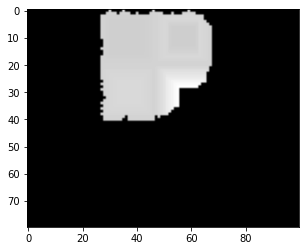

In [23]:
imgplot = plt.imshow(output_depth_image, cmap='gray')